# Machine Learning for Cryptocurrency Trading
## An Introduction

This is a brief crash course on how to use machine learning to make cryptocurrency trading decisions. 

The target audience is a programmer with at least some familiarity with supervised learning techniques, though not necessarily any finance or trading experience. This certainly isn't a comprehensive implementation of cutting-edge techniques, but rather a clean and logical place to start. References to more advanced strategies, especially those aimed specifically at time-series work, will be noted. 

Trading is definitionally zero-sum: every transaction has two sides and if one wins the other must lose. As you might imagine then, building a money making machine for a zero-sum game is quite competitive. We'll just scratch the surface here, but it's a really fun problem to grind on because (1) the stakes are real and (2) you develop skills that generalize to a lot of interesting problems.

**The goal here is to predict price movements and build a profitable trading strategy based on those predictions.** 

Data collection and trade execution vary by exchange, but are generally easy either manually or via API. (See [this repo](https://github.com/danpaquin/gdax-python) for a nice Python package for interacting with the [GDAX API](https://docs.gdax.com).) Sample data from GDAX is provided for this notebook.

<a id='toc'></a>
### Table of Contents:
This course is broken down into 5 sections:
1. [Overview](#section1)
2. [Cleaning Raw Trading Data](#section2)
  - Transform GDAX's API output into data that can be easily modeled
3. [Feature Engineering](#section3)
  - Transform the nominal values of raw data into normalized variables which can be used to build generalizable predictive models
4. [Predicting Price](#section4)
  - Train models on historical data and assess performance based on out-of-sample fit
5. Optimizing Trading Strategy
  - Given price predictions, use the return assessment framework to iterate through different trading strategies, optimizing for maximum return

The repo for this course includes a library that will perform much of the work. The code is in ```/ml_for_trading/ml4t```. This should be a useful jumping point from which you can build your own strategies.

<a id='section1'></a>

[Jump back to the TOC](#toc)
# 1. Overview
## Approach: Inference & Prediction
Broadly, there are two things you can do with machine learning: 
1. You can develop an understanding of how systems work: how is an output generated as a function of some input. This is **inference**.
2. You can attempt to guess, as accurately as possible, what output will result from some input. This is **prediction**. 

This notebook is focused almost exclusively on prediction. If you can systematically predict which way the price of a cryptocurrency is going to move, and can act efficiently to trade based on that information, you will make above-market returns. 

Ideally, strong inference work underpins the development of prediction systems; a logical understanding of the system should guide prediction modeling decisions. Here, however, there may not be much sound inference to be drawn because cryptocurrencies aren't _really_ underlying any meaningful utility yet. Given this, and a desire for brevity, it makes sense to focus on developing a solid prediction architechture.

## Approach: Fundamental & Technical/ Quantitative Analysis
Another distinction broadly classifies the two types of equity trading strategies:
1. **Fundamental Analysis** attempts to evaluate an asset's intrinsic value. For example, based on the performance of a company, its assets and liabilities, the state of the market, and the overall economy, what is the true present value. Cryptocurrencies are currently being valued not for what they are, but what they could be. The evolution will likely be weirder than we think. High uncertainty about not just the probability of specific outcomes, but even the topography of possible outcomes isn't a tractable machine learning problem.
2. **Technical and Quantitative Analysis** attempts to predict future price and volume movements based on mathematical relationships within historical trading data, or any other quantifiable source of information. This is a great place for machine learning.

## Data Sources
This notebook will only use price and volume data for Bitcoin (though Ethereum and Litecoin data are also inculded in ```/data``` for your enjoyment). Each observation is called a "candlestick" because of what it looks like when graphed, and includes the open, close, high and low price, as well as volume traded, for a specific period of time (1 minute in this case). This is about the most parsimonious dataset with which you could imagine modeling price movements.

There are many other data sources you should consider if you want to get serious with your algorithmic trading:
- Other cryptocurrencies:
 - Price and volume of the many other cryptocurrencies
 - Statistical relationships between these assets (_e.g.,_ relative prices movements have converged and decoupled at various points)
- Deeper exchange data:
 - By-order data: candle stick data, which we're going to use here, are an aggregation of one or more orders over a set period of time. Though noticably more challenging to handle, by-order data could provide granularity that yeilds additional predictive power
 - Order book data: candle stick and by-order data record the trades that actually occured. What about orders that went unfilled? Complete orderbook data would add a lot of additonal market context. It would also add a lot more complexity: orders can be outstanding for an arbitrary amount of time and can end in three different terminal states: cancelled, partially filled, or fully filled.
- Network information: the information stored on an asset's blockchain; what's included varies by asset, but some of the common things include
 - Nodes: number and power of miners on the network
 - Transaction fees
 - Amount and velocity of transactions
 - Number and concentration of wallets
- Other exchanges: there are a lot of exchanges that have meaningful liquidity. Some may lead or lag in price movements. There may even be pure arbitrage opportunities (though you'd have to consider transaction time and fees)
- News sentiment: Reddit, Telegram, Twitter, various other chat communities, and media coverage
- Code: many open source projects save their code, and incremental updates, to public GitHub repos. Summarizing the evolution of these code bases could indicate some rough signal of quality or momentum
 - Volume and size of commits
 - Number and quality of contributors
- Non-cryptocurrency assets and macro economy indicators
- Major events: some way to capture big changes to the relevant currencies (_e.g.,_ anouncements of adoption by large institutions), or environment (_e.g.,_ SEC regulation)

## Tools:
The code in this course is Python 3.6. It relies on a number of popular libraries:

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import ml4t  # ~/ml4t in this repo; e.g., ml4t.TradeData()

# Viewing options
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
pd.options.display.float_format = '{:,.4f}'.format  # 2 decimal places
# %config InlineBackend.figure_format = 'retina'   # if viewing on MBP retina and want high res plots


<a id='section2'></a>

[Jump back to the TOC](#toc)
# Section 2: Cleaning Raw Data
Raw trading data were pulled from GDAX's API and saved as CSV files. In this section, these raw data are cleaned and prepared for price prediction modeling.


In [2]:
REPO_PATH = %pwd
DATA_PATH = REPO_PATH + "/data/"
DATA_STARTTIME = '2017-01-01 00:00:00'
DATA_ENDTIME   = '2018-03-15 23:59:59'

In [3]:
# Create second-level index for df based on begining and end or data range
datetimes = pd.date_range(DATA_STARTTIME, DATA_ENDTIME, freq='min')
datetimes[0:10]

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:01:00',
               '2017-01-01 00:02:00', '2017-01-01 00:03:00',
               '2017-01-01 00:04:00', '2017-01-01 00:05:00',
               '2017-01-01 00:06:00', '2017-01-01 00:07:00',
               '2017-01-01 00:08:00', '2017-01-01 00:09:00'],
              dtype='datetime64[ns]', freq='T')

In [4]:
# Create df with datetimes range as index
df_template = pd.DataFrame(index=datetimes)
df_template.index.name = 'dt'

In [5]:
# Import csv data

# Row names
def import_data(exchange, periods):

    COLS = ['dt'
                , exchange +'_low'
                , exchange + '_high'
                , exchange + '_open'
                , exchange + '_close'
                , exchange + '_coin_vol']

    # Periods of data
    PERIODS = periods  # ['2017', '2018_through_03-15']

    # Exchange df
    df_exchange = pd.DataFrame(columns = COLS)

    for q in PERIODS:
        df_tmp = pd.read_csv(DATA_PATH + str(q) + '_' + exchange + '_60sec_candles.csv', header=None)
        df_tmp.columns = COLS
        df_exchange = df_exchange.append(df_tmp)
    del df_tmp
    df_exchange['dt'] = pd.to_datetime(df_exchange['dt'], unit='s')
    df_exchange = df_exchange.set_index('dt')
    
    # Overlay data on template df (with _every_ minute in series, not just those traded)
    return df_template.join(df_exchange, how='outer')

df_btc = import_data('USD-BTC', ['2017', '2018_through_03-15'])
#df_eth = import_data('USD-ETH', ['2017', '2018_through_03-15'])
#df_ltc = import_data('USD-LTC', ['2017', '2018_through_03-15'])

In [6]:
display(df_btc.tail())
#display(df_eth.tail())
#display(df_ltc.tail())

,USD-BTC_low,USD-BTC_high,USD-BTC_open,USD-BTC_close,USD-BTC_coin_vol
dt,,,,,
2018-03-15 23:55:00,"8,247.7800","8,254.9900","8,247.7800","8,254.9900",22.1226
2018-03-15 23:56:00,"8,254.9900","8,258.1100","8,255.0000","8,255.0000",8.3839
2018-03-15 23:57:00,"8,255.0000","8,260.0000","8,255.0000","8,260.0000",4.3908
2018-03-15 23:58:00,"8,259.9900","8,260.0000","8,259.9900","8,259.9900",1.8671
2018-03-15 23:59:00,"8,259.9900","8,260.0000","8,260.0000","8,259.9900",2.7873


### Sanity Check Raw Data

In [9]:
# Density of data
print('Total minutes over time series: {}'.format(df_btc.shape[0]))

# % of seconds with trade
print('% minutes in time series with {} trades: {}'.format('[USD-BTC]', [df_btc['USD-BTC_low'].notna().sum()/df_btc.shape[0] ]))
                                                                                          #,df_eth['USD-ETH_low'].notna().sum()/df_eth.shape[0]
                                                                                          #,df_ltc['USD-LTC_low'].notna().sum()/df_ltc.shape[0]]))

Total minutes over time series: 632160
% minutes in time series with [USD-BTC] trades: [0.97854182485446717]


In [10]:
# % of minute candles with >0 volume in which high and low price are NOT the same
# Range of w/i second price variation: high / low
# Note: the more variation of price w/i a candle, the more likely the USD volume estimate will be incorrect

for ex in ['USD-BTC']:  # 'USD-ETH', 'USD-LTC'
    if ex=='USD-BTC': dfcheck = df_btc 
    elif ex=='USD-ETH': dfcheck = df_eth 
    else: dfcheck = df_ltc
    
    high_low_magnitude = (dfcheck.loc[:, ex + '_high'] / dfcheck.loc[:, ex + '_low']) - 1

    print('% of {} minute trade candles w/ multiple prices : {}'.format(ex, (high_low_magnitude[high_low_magnitude.notna()] != 0.0).sum() / high_low_magnitude.notna().sum()))
    print('Max {} (high - low)/low : {}'.format(ex, high_low_magnitude.max()))
    print('Mean {} (high - low)/low : {}'.format(ex, high_low_magnitude.mean()))
    print('Median {} (high - low)/low : {}'.format(ex, high_low_magnitude.median()))

    del high_low_magnitude, dfcheck

% of USD-BTC minute trade candles w/ multiple prices : 0.9128557456817465
Max USD-BTC (high - low)/low : 0.3184444444444443
Mean USD-BTC (high - low)/low : 0.0010631585507540706
Median USD-BTC (high - low)/low : 0.00039111883691544946


31.8% of seconds have trades. Of those seconds with trades, 17.1% have multiple prices within the second. The highest w/i second difference between high and low is 8%, and the mean is 0.007%. Large variation is possible when, for instance, a big market order is placed and, in order to fulfill the volume, the market moves deep into the outstanding limit order book. 

The technique used to calculate the USD volume of a second is (open_price + close_price) / 2 * coin_volume. This should usually be quite accurate given the low variation in w/i second prices.

### Clean and Aggregate Data
ml4t.TradeData() is used to clean and aggregare the raw data. ```TradeData.clean_df_s()``` method will perform the following:
 - Fill forward missing data
  - For periods without trades, the low, high, open, and close price are set equal to the most recent closing price. Volume is set to 0.
 - USD volume is calculated as ```(open_price + close_price) / 2 * coin_volume```
 - Period return percentage is calculated as ```(close_price - open_price) / open_price```
 - Aggregations of the data are created as the following attributes of the object:
  - Hour-level: ```TradeData.df_h```
  - Day-level: ```TradeData.df_d```

Note: there may be leading NaNs in these series which can cause issues down the line. A note on how many leading NaN periods there are will be printed.

In [9]:
trade_data_btc = ml4t.TradeData(df_btc)
trade_data_btc.clean_df_m()

Note: df has 0 leading NaN periods.
Minute-level data have been cleaned.
Minute, hour, and day-level data are available as .df_m, .df_h, and .df_d, respectively.


In [10]:
trade_data_eth = ml4t.TradeData(df_eth)
trade_data_eth.clean_df_m()

Note: df has 0 leading NaN periods.
Minute-level data have been cleaned.
Minute, hour, and day-level data are available as .df_m, .df_h, and .df_d, respectively.


In [11]:
trade_data_ltc = ml4t.TradeData(df_ltc)
trade_data_ltc.clean_df_m()

Note: df has 25 leading NaN periods.
Minute-level data have been cleaned.
Minute, hour, and day-level data are available as .df_m, .df_h, and .df_d, respectively.


### Visualizing Data

Before building predictive models with the cleaned and formatted data, it's important to 
develop a feel for _what_ is being modeled. The ml4t library includes a couple of functions that help visualize the cleaned trade data.

For example, rolling statistics are particularly useful for modeling time series data. Below are several key variables plotted with rolling mean and standard deviations. One simple trading strategy, proposed by a guy named John Bolllinger, is to buy when a price falls below the rolling mean - 2 standard deviations, and sell when it exceeds the rolling mean + 2 standard deviations. ```ml4t``` has  functions that allow much more nuanced models to be trained and tested easily, but this is a helpful heuristic to keep in mind while looking at visualizations as it has the flavor of things our models could pick up.

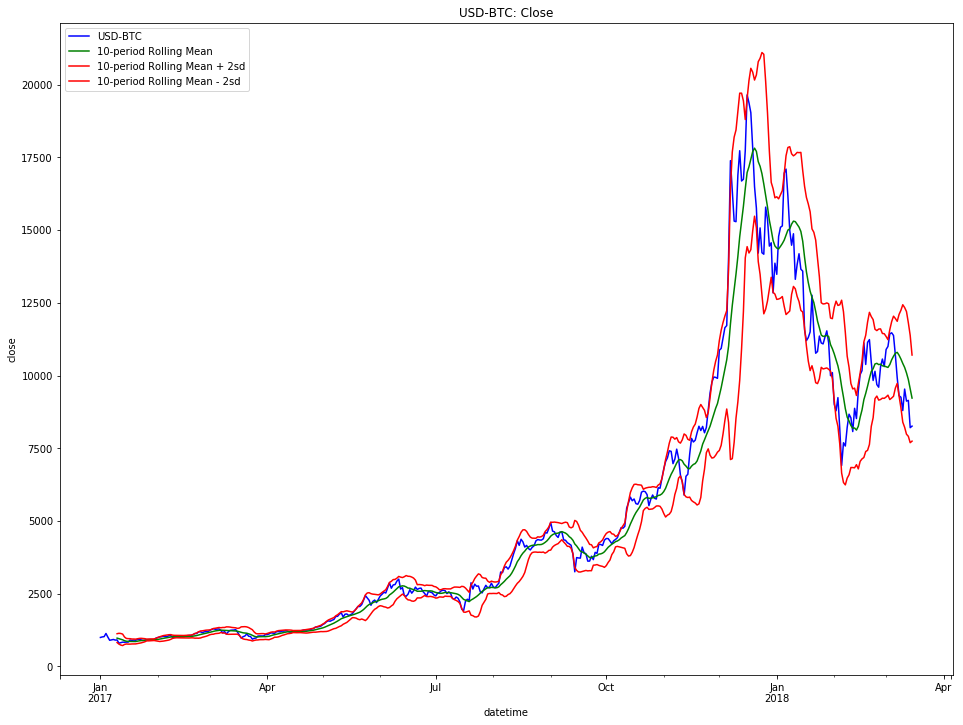

In [12]:
# Daily closing price, 10-day rolling mean and Bollinger Bands
ml4t.plot_rm(trade_data_btc.df_d, var='close', n=10, bollinger=True)

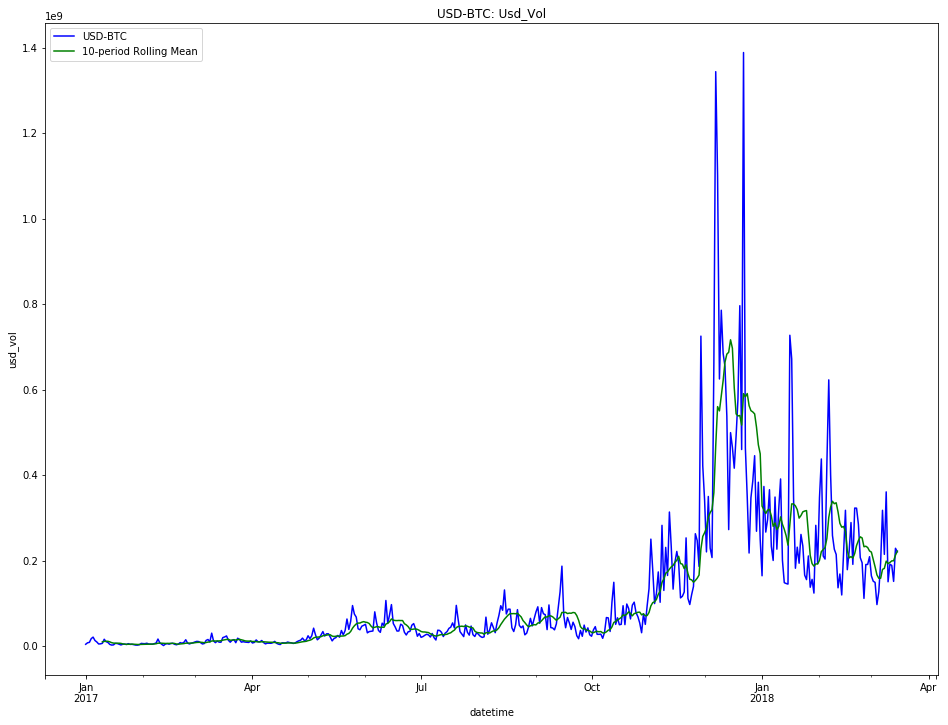

In [13]:
# Daily USD volume, 10-day rolling mean and Bollinger Bands
ml4t.plot_rm(trade_data_btc.df_d, var='usd_vol', n=10, bollinger=False)

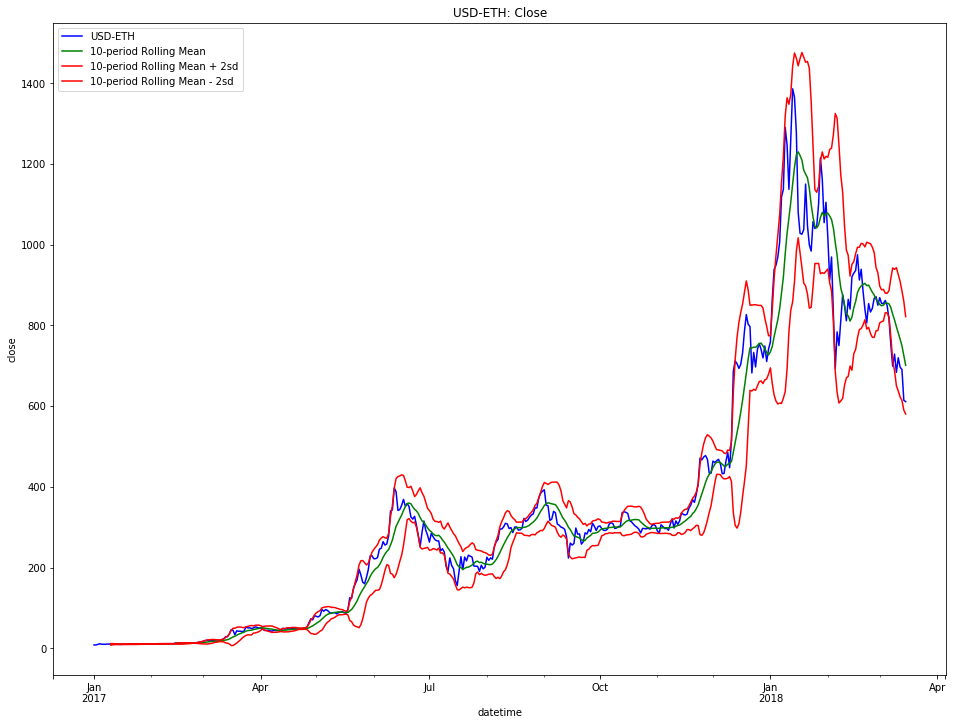

In [14]:
# Daily closing price, 10-day rolling mean and Bollinger Bands
ml4t.plot_rm(trade_data_eth.df_d, var='close', n=10, bollinger=True)

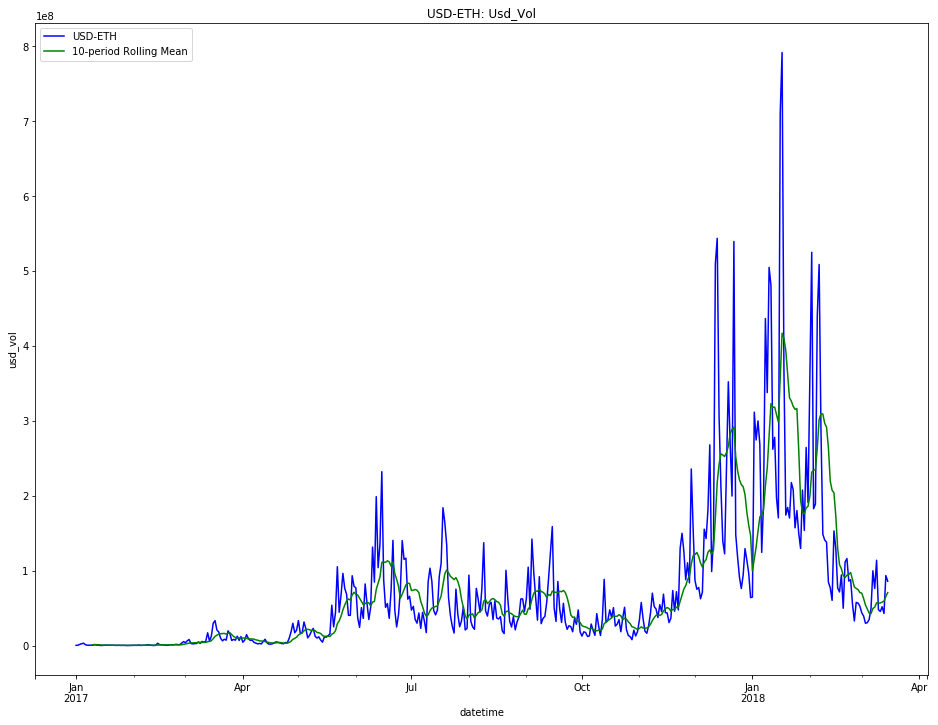

In [15]:
# Daily closing price, 10-day rolling mean and Bollinger Bands
ml4t.plot_rm(trade_data_eth.df_d, var='usd_vol', n=10, bollinger=False)

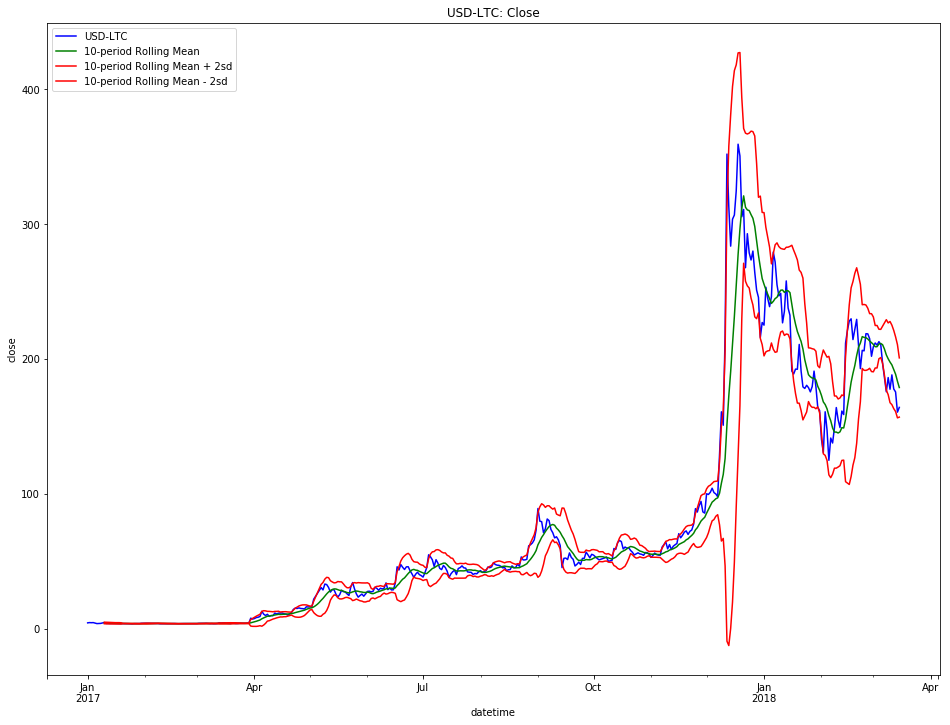

In [16]:
# Daily closing price, 10-day rolling mean and Bollinger Bands
ml4t.plot_rm(trade_data_ltc.df_d, var='close', n=10, bollinger=True)

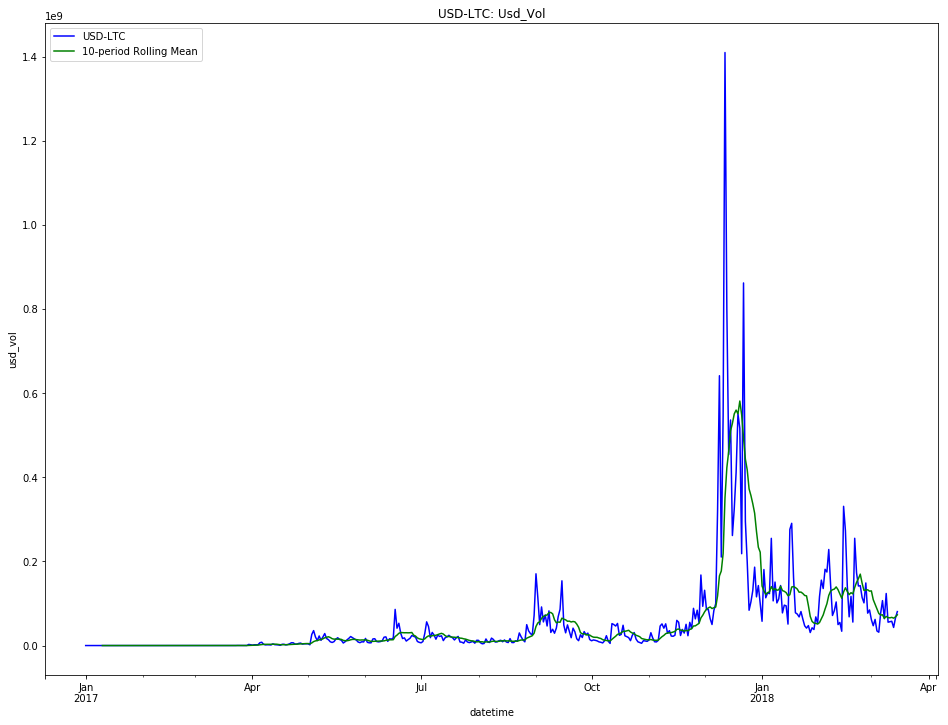

In [17]:
# Daily closing price, 10-day rolling mean and Bollinger Bands
ml4t.plot_rm(trade_data_ltc.df_d, var='usd_vol', n=10, bollinger=False)

2017-01-01 to 2018-03-15 was a period of dramatic net price appreciation. Recall, trading strategies will be assessed _relative_ to market performance. So, a strategy is only considered successful if it beats market performance, net of fees. 

Some initial portion of these data will be used to train models, and the end will be used as a hold-out testing set. The ml models built here will only know what they've been trained on, so they may be fragile to markedly different environments. For this reason, it's important to validate model performance on a broad set of testing data. Understanding when a model is strongly predictive and when accuracy breaks down are critical parts of building a robust predictive ml model.

My prior is that, using technical + quantitative analysis (_ie.,_ without strong fundamental analysis), the further into the future you make predictions, the less accurate they will be. This is based on the idea that there's just much more that can happen in an hour than in a minute; the topography of possible states of the world is larger. Imagine your dog runs away. If she's been gone for an hour, you have to search a much greater area than if she's only been gone for a minute. The search radius necessary increases over time.

The same principle applies here. However, there are tradeoffs to market prediction on increasingly small time periods: market liquidity and transaction costs. With respect to market liquidity, if there isn't anyone to take the other size of the trade, a prediction can't be acted upon. Or, if the order book is shallow relative to the size of a market order, that order could meaningfully move the price. With respect to transaction costs: we'll be assuming fees are a percentage of the volume traded. For a trade to be profitable, it must move in the expected direction _more_ than the transaction fee of the trade. Within period price volatility increases with the size of the period. So, we need to predict periods that are at least large enough to offer the possibility for price changes larger than transaction fees.

One other potential problem with very small time intervals is trade execution time. For example, you may simply not be able to submit an order within a prediction window that's a small fraction of a second.

The following sections will focus on predicting hour-level data, abstracting away from liquidity and execution time concerns. (Predicting even some part of the future is a hard enough problem to start with.) Depending on the liquidity of the exchange you're trading on and the size of your orders, liquidity may be a major factor you have to consider in practice. At the hour-level, trade execution time isn't nearly as large of a concern.

To get a sense of what the data look like at the hour-levlel, see the plots below. You're encouraged to explore these data further by plotting other time intervals.

In [18]:
# What does the distribution of hourly returns look like?
display(trade_data_btc.df_h['USD-BTC_return'].abs().describe())
display(trade_data_eth.df_h['USD-ETH_return'].abs().describe())
display(trade_data_ltc.df_h['USD-LTC_return'].abs().describe())

count   10,536.0000
mean         0.0075
std          0.0093
min          0.0000
25%          0.0018
50%          0.0045
75%          0.0098
max          0.1440
Name: USD-BTC_return, dtype: float64

count   10,536.0000
mean         0.0095
std          0.0125
min          0.0000
25%          0.0022
50%          0.0054
75%          0.0120
max          0.1676
Name: USD-ETH_return, dtype: float64

count   10,536.0000
mean         0.0108
std          0.0147
min          0.0000
25%          0.0025
50%          0.0062
75%          0.0134
max          0.3419
Name: USD-LTC_return, dtype: float64

GDAX's market orders cost ~0.3%. Most hourly price changes are greater that this, so at least we're dealing with a scale that frequently has the possibility to cover transaction costs  (if we can correctly predict the movement, of course).

<a id='section3'></a>

[Jump back to the TOC](#toc)
# Section 3: Feature Engineering
[[TODO: only doing BTC from here. Either add other CCs after or strip ETH, LTC from above.]]

Before we attempt to build a price prediction model, we'll create potential model features.

One of the main goals of this feature engineering is to build variables that are _normalized_. This means we're adjusting the raw values to a common scale that is comparable across the time series. For example, one day the price might move from \$500 to \$1000. Another day it might move from \$10,0000 to \$10,500. Although both of these days resulted in a \$500 increase in value, the normalized changes are dramatically different: the first increased 100%, while the second only increased 5%. Percentage increase is a normalized metric and is generally more easily comparable across observations than an absolute metric. Building models based on normalized features tends to make them better at predicting the future because the measurements account for context in which they were calcualted.

[[TODO: Discuss technical/ quant split. link to papers]]

Price prediction based strictly on historical price and volume is called "technical analysis" in finance. There is _a lot_ of finance literature on different metrics for this type of prediction. Here, however, we'll build just a few that are closely related to common normalized statistics across domains:
- Normalized price dispersion: rolling std of closing price / rolling mean of closing price
- Price diversion from rolling mean: (period closing price - rolling mean of closing price) / rolling std of closing price; (note: Bollinger Bands are simply +2/-2 thresholds for this measurement)
- Rolling mean return
- Normalized volume dispersion: usd volume rolling std / usd volume rolling mean
- USD volume diverson from rolling mean: (period usd volume - rolling mean of usd volume) / rolling std of usd volume
- Boolean for if return is positive
- \# of periods in which return has maintained positive return
- \# of periods in which return has maintained negative return (we won't be including interaction terms in our models, so we want both the negative and positive version of this metric)

### Weaknesses of Approach
[[TODO: refine section]]
- assumes the future will be driven by the same things as the past
- misses a lot of obvious sources of data, notably EVENTS
  - eg., SEC says cryptocurrencies are illegal -> prices will plumet. features dont capture SEC statements

### For future development: 
- All of these features are descriptions of what's happening to _that_ cryptocurrency. An obvious next step is to add _between_ cryptocurrency features. For example, how do prices correlate with each other? Does this correlation wax and wane in a predictable way?
- The number of periods over which rolling statistics are calculated is something that should be sensitivity tested. The default in ```.calc_features()``` is 10, though this can be changed and multiple rolling trends can be calculated in the same feature set. In your own work, once you have found a good model, try re-specifying it with different rolling feature windows to see if you can improve performance.

In [19]:
Y_btc, X_btc = ml4t.calc_features(trade_data_btc.df_h
                                 , rolling_periods = [10]
                                 , y_binary = False)

In [20]:
# Dependent var
#Y_btc.mean()
#Y_btc.median()

In [21]:
#X_btc.head()  # Features

[[TODO: clean up]]

### Split into Train and Test
- Roll-forward cross-validation: test data should always come after train data
- Be very careful not to let information about the future be brought backwards in time (_eg.,_ mean of all prices in observation 0 would bring info back in time).
- Simple % test and 1-% train
- Next steps: run sensitivities on this split; shorter/longer total time trends; cross-validation sets within model specification
- I'll actually set aside the last 10% to be used to assess "real world" performance. In parctice the "test" data set above will be used for cross-validation and model selection. The first section of this data will be split into test/train data.
  - Recap: 
   - Training Data: January 1, 2017 - November 11, 2017
   - Validation Data: November 12, 2017 - January 29, 2018
   - Real-world performance test data: January 30, 2018 - March 15, 2018

### Balancing Positive and Negative Return Periods
- upsample ensures that in (only train data), there are equal number of positive and negative return periods to avoid biasing the model

OLD: The feature creation method below also forces the resulting dataset to have the same number of positive and negative return periods. It does this by oversampling the minority class. The observations of the less-likely return type are randomly duplicated until there are as many positive as negative return periods. This helps avoid biasing the model towards one type of outcome. (Like all modeling decisions, it comes with tradeoffs, but we won't dive into those here. This oversampling of the minority can be easily togged off in the method if you prefer.)

In [22]:
# Find create 90-10 train/test split
i_split = int(Y_btc.shape[0] * (1 - 0.1))

# Y
Y_btc_model = Y_btc.iloc[0:i_split,]
Y_btc_test = Y_btc.iloc[i_split:,]

# X
X_btc_model = X_btc.iloc[0:i_split,]
X_btc_test = X_btc.iloc[i_split:,]

In [23]:
Y_btc_train, X_btc_train, Y_btc_val, X_btc_val = ml4t.split_test_train(Y_btc_model
                                                                         , X_btc_model
                                                                         , test_pct = 0.2
                                                                         , upsample = True)

<a id='section4'></a>

[Jump back to the TOC](#toc)
# 4. Predicting Price
This section features several attempts to predict future prices based on historical data. The high-level modeling strategy is as follows:

### Continuous Dependent Variable
The thing we'll try to predict here is **return percentage for the next hour**. This is a continuous value. 

Alternatively, we could try to model this as a classification problem (_ie.,_ will the price an hour from now be higher or not). Classification problems have a really nice, intuitive set of performance creteria. In this situation, however, transaction fees are meaningful relative to the typical period change. In order to build a successful strategy with market orders we have to be able to say something about _how large_ of a return we expect in the future, not just the direction.

### Measure of Accuracy
[[TODO: clean up]]
- ml models will use off the shelf loss functions: basically optimizing for some sense of aggregate model accuracy 
- Mean Absolute Error and the distribution of Absolute Error in test data is something to keep an eye on because of how directly it relates to the threshold of making trades that at least cover fees
- Mean Absolute Percentage Error could be a good metric for how close predictions tend to be, though keep in mind this is percent error of a percent prediction (nothing wrong with that, just complex)

You can also imagine a strategy where we're not concerned with the mean error, but rather identifying some subset of period predicitons (ideally large ones) that we could model very well, even if the average prediction isn't very good. Then, we could just trade during periods that matched that subset. That gets complicated quickly, so we're not going to attempt that here.

In the next section, predicted odds of future period price increase will be used to build a trading strategy. Simple optimization of net-of-fee returns based threshold will determine the final trading strategy (e.g., "buy if predicted odds of price increase is >=X%").

### Considering Fees and Price Impact of Trading
Predicting the future return is just one component of building a complete trading strategy. In the following section we'll look at making trading decisions in the context of transaction costs and the fact that trading impacts the market price.

## Random Forest
The first model we'll use to attempt to predict future returns is random forest. This ensemble learner aggregates the prediction of many decision trees, each split at random creiteria. Every tree is created from a bootstrap aggregated ("bagged") set of training observations the size of the training data. This means that every tree in the forest is created on its own training dataset. Each of those datasets is created by sampling, with replacement, from the orginal training set for a "bag" that's as big as the original training set.

When we use the random forest to predict an observation, each of the trees in the forest is used to calculate its own answer, then the answers are averaged. Random forests are plesantly intuitive and a great first model to try for many machine learning problems. 

There are two main hyperparameters of the model we'll focus on tuning:
- Number of trees in the forest
- Minimum leaf size

There could certainly be interaction between these two criteria, but we'll evaluate them sequentially here.


In [24]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [25]:
#tree_size = [i for i in range(10, 51) if not (i % 2)]
#tree_size_train_mae = []
#tree_size_val_mae = []
#
#for t in tree_size:
#    rf = RandomForestRegressor(n_estimators = t
#                               , min_samples_leaf = 5
#                               , criterion='mae'
#                               , random_state = 64)
#    rf.fit(X_btc_train, Y_btc_train)
#    tree_size_train_mae.append(mean_absolute_error(Y_btc_train, rf.predict(X_btc_train)))
#    tree_size_val_mae.append(mean_absolute_error(Y_btc_val, rf.predict(X_btc_val)))
#    print("finished: {}; validation mae: {}".format(t, tree_size_val_mae[-1]))

In [26]:
#TODO: run through 60 trees and graph val vs train

MAE is lowest in the validation data at 44 trees (~0.00535), so we'll use this going forward. Now to tune the leaf size:

In [27]:
#leaf_size = [i for i in range(2, 21) if not (i % 2)]
#leaf_size_train_mae = []
#leaf_size_val_mae = []
#
#for l in leaf_size:
#    rf = RandomForestRegressor(n_estimators = 44
#                               , min_samples_leaf = l
#                               , criterion='mae'
#                               , random_state = 64)
#    rf.fit(X_btc_train, Y_btc_train)
#    leaf_size_train_mae.append(mean_absolute_error(Y_btc_train, rf.predict(X_btc_train)))
#    leaf_size_val_mae.append(mean_absolute_error(Y_btc_val, rf.predict(X_btc_val)))
#    print("finished: {}; validation mae: {}".format(l, leaf_size_val_mae[-1]))

In [28]:
#TODO: run for range(1, 11) and graph validation vs train

MAE is lowest for a leaf size of 5, so we'll use that going forward.

In [29]:
#from sklearn.ensemble import AdaBoostRegressor
#
#tree_size = [i for i in range(10, 51)]
#tree_size_train_mae = []
#tree_size_val_mae = []
#
#for t in tree_size:
#    rf = AdaBoostRegressor(RandomForestRegressor(min_samples_leaf = 5
#                               , criterion='mae'
#                               , random_state = 64)
#                           , n_estimators = t
#                           , random_state = 64)
#    rf.fit(X_btc_train, Y_btc_train)
#    tree_size_train_mae.append(mean_absolute_error(Y_btc_train, rf.predict(X_btc_train)))
#    tree_size_val_mae.append(mean_absolute_error(Y_btc_val, rf.predict(X_btc_val)))
#    print("finished: {}; validation mae: {}".format(t, tree_size_val_mae[-1]))

In [30]:
# For perspective, guessing the training mean return in the val set results in the following MAE:
mean_absolute_error(Y_btc_val, [Y_btc_train.mean() for i in range(Y_btc_val.shape[0])])


0.010996086375254661

In [31]:
# even if you knew the test window mean return
mean_absolute_error(Y_btc_test, [Y_btc_test.mean() for i in range(Y_btc_test.shape[0])])

0.010534314525097925

In [32]:
# even if you knew the test window mean return
mean_absolute_error(Y_btc_test, [0.0 for i in range(Y_btc_test.shape[0])])

0.010533850241337836

In [33]:
Y_btc_test.index

DatetimeIndex(['2018-01-31 03:00:00', '2018-01-31 04:00:00',
               '2018-01-31 05:00:00', '2018-01-31 06:00:00',
               '2018-01-31 07:00:00', '2018-01-31 08:00:00',
               '2018-01-31 09:00:00', '2018-01-31 10:00:00',
               '2018-01-31 11:00:00', '2018-01-31 12:00:00',
               ...
               '2018-03-15 14:00:00', '2018-03-15 15:00:00',
               '2018-03-15 16:00:00', '2018-03-15 17:00:00',
               '2018-03-15 18:00:00', '2018-03-15 19:00:00',
               '2018-03-15 20:00:00', '2018-03-15 21:00:00',
               '2018-03-15 22:00:00', '2018-03-15 23:00:00'],
              dtype='datetime64[ns]', name='dt', length=1053, freq='H')

In [34]:
trade_data_btc.df_h.loc['2018-01-31 03:00:00']

USD-BTC_low            9,800.0000
USD-BTC_high          10,002.8800
USD-BTC_open          10,002.8700
USD-BTC_close          9,894.7200
USD-BTC_coin_vol       1,009.1685
USD-BTC_usd_vol    9,988,528.4819
USD-BTC_return            -0.0108
Name: 2018-01-31 03:00:00, dtype: float64

In [35]:
trade_data_btc.df_h.loc['2018-03-15 23:00:00']

USD-BTC_low            8,225.0000
USD-BTC_high           8,323.9900
USD-BTC_open           8,323.9900
USD-BTC_close          8,259.9900
USD-BTC_coin_vol         702.7268
USD-BTC_usd_vol    5,818,472.2631
USD-BTC_return            -0.0077
Name: 2018-03-15 23:00:00, dtype: float64

In [36]:
(Y_btc_test + 1).product()

0.83483767672369791

In [37]:
from sklearn.ensemble import AdaBoostRegressor
# By period error using tree
rf = AdaBoostRegressor(RandomForestRegressor(min_samples_leaf = 5
                           , criterion='mae'
                           , random_state = 64)
                       , n_estimators = 40
                       , random_state = 64)
rf.fit(X_btc_train, Y_btc_train)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=64, verbose=0, warm_start=False),
         learning_rate=1.0, loss='linear', n_estimators=40,
         random_state=64)

In [38]:
rf.predict(X_btc_val)

array([ 0.0118618 ,  0.01381594,  0.00882279, ..., -0.02233133,
        0.00831174,  0.01036748])

In [39]:
Y_btc_val.head()

dt
2017-11-13 04:00:00    0.0180
2017-11-13 05:00:00    0.0259
2017-11-13 06:00:00    0.0058
2017-11-13 07:00:00   -0.0010
2017-11-13 08:00:00   -0.0008
Freq: H, Name: USD-BTC_return, dtype: float64

In [45]:
pd.join([pd.DataFrame(Y_btc_val), pd.DataFrame(rf.predict(X_btc_val), index=Y_btc_val.index)]).head()

AttributeError: module 'pandas' has no attribute 'join'

In [46]:
pd.DataFrame(Y_btc_val).join(pd.DataFrame(rf.predict(X_btc_val), index=Y_btc_val.index))

,USD-BTC_return,0
dt,,
2017-11-13 04:00:00,0.0180,0.0119
2017-11-13 05:00:00,0.0259,0.0138
2017-11-13 06:00:00,0.0058,0.0088
2017-11-13 07:00:00,-0.0010,-0.0065
2017-11-13 08:00:00,-0.0008,-0.0119
2017-11-13 09:00:00,0.0193,0.0147
2017-11-13 10:00:00,0.0070,0.0126
2017-11-13 11:00:00,0.0161,0.0136
2017-11-13 12:00:00,0.0275,0.0301
